In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
df  = pd.read_csv('../data/train_set.csv')

In [3]:
def convert_to_time(df, cols):
    df[cols] = df[cols].apply(pd.to_datetime)
    return df

def convert_to_string(df, cols):
    df[cols] = df [cols].astype('str')
    return df

def convert_to_category(df, cols):
    df[cols] = df [cols].astype('category')
    return df

def estadisticas_categoricas(xtrain, ytrain, variable):
    df = pd.DataFrame(xtrain.join(ytrain).groupby(variable).target.mean()).reset_index()
    df.columns = [str(variable[0]),str(variable[0] + '_media_target')]
    df[str(variable[0] + '_mediana_target')] = pd.DataFrame(xtrain.join(ytrain).groupby(variable).target.median()).reset_index()['target']
    df[str(variable[0] + '_std_target')] = pd.DataFrame(xtrain.join(ytrain).groupby(variable).target.std()).reset_index()['target']
    return df

def create_time_variables(df):
    df['total_wait_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
    df['aproved_wait_time'] = (df['order_aproved_at'] - df['order_purchase_timestamp']).dt.days
    df['estimated_wait_time'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
    df['arrived_hour'] = df['order_delivered_customer_date'].dt.hour
    df['arrived_day'] = df['order_delivered_customer_date'].dt.day
    df['arrived_week_day'] = df['order_delivered_customer_date'].dt.dayofweek
    return df

In [4]:
cols = ['order_purchase_timestamp', 'order_aproved_at', 
        'order_estimated_delivery_date', 'order_delivered_customer_date']
cols_string = ['order_status', 'customer_city', 'customer_state', 
               'product_category_name_english']
df = convert_to_time(df, cols)
df = create_time_variables(df)


In [5]:
x = df.drop(['target', 'ID'],axis=1)
y = df.target

In [6]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, random_state=12, 
             test_size=0.30)

In [7]:
gbr = GradientBoostingRegressor(n_estimators=600, 
    max_depth=5, 
    learning_rate=0.01, 
    min_samples_split=3)

gbr = XGBRegressor()


In [8]:
producto = estadisticas_categoricas(xtrain, ytrain, ['product_category_name_english'])
xtrain = xtrain.merge(producto, how='left')
xtest = xtest.merge(producto, how='left')

In [9]:
entrega = estadisticas_categoricas(xtrain, ytrain, ['order_status'])
xtrain = xtrain.merge(entrega, how='left')
xtest = xtest.merge(entrega, how='left')

In [10]:
x_train = pd.get_dummies(xtrain['order_status'])#,  drop_first = True)
x_test = pd.get_dummies(xtest['order_status'])#,  drop_first = True)

x_test = x_test.reindex(columns = x_train.columns, fill_value=0)
xtrain = x_train.join(xtrain.drop('order_status', axis=1))
xtest = x_test.join(xtest.drop('order_status', axis=1))

In [11]:
estado = estadisticas_categoricas(xtrain, ytrain, ['customer_state'])
xtrain = xtrain.merge(estado, how='left')
xtest = xtest.merge(estado, how='left')


In [12]:
xtrain.columns

Index(['canceled', 'delivered', 'invoiced', 'processing', 'shipped',
       'unavailable', 'order_products_value', 'order_freight_value',
       'order_items_qty', 'order_sellers_qty', 'order_purchase_timestamp',
       'order_aproved_at', 'order_estimated_delivery_date',
       'order_delivered_customer_date', 'customer_city', 'customer_state',
       'customer_zip_code_prefix', 'product_category_name_english',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'total_wait_time', 'aproved_wait_time',
       'estimated_wait_time', 'arrived_hour', 'arrived_day',
       'arrived_week_day', 'product_category_name_english_media_target',
       'product_category_name_english_mediana_target',
       'product_category_name_english_std_target', 'order_status_media_target',
       'order_status_mediana_target', 'order_status_std_target',
       'customer_state_media_target', 'customer_state_mediana_target',
       'customer_state_std_target'],
      dtype='

In [13]:
cols = [ 
    'order_products_value'
    ,'order_freight_value'
    ,'product_description_lenght'
    ,'product_name_lenght'
    ,'product_photos_qty'
    ,'order_items_qty'
    ,'order_sellers_qty'
    ,'total_wait_time'
    ,'aproved_wait_time'
    ,'estimated_wait_time'
    ,'arrived_hour'
    ,'arrived_day'
    ,'arrived_week_day'
#    ,'canceled'
#    ,'delivered'
#    ,'invoiced'	
#    ,'processing'	
#    ,'shipped'	
#    ,'unavailable'
    ,'product_category_name_english_media_target'
#    ,'product_category_name_english_mediana_target'
#    ,'product_category_name_english_std_target'
    ,'order_status_media_target'
#    ,'order_status_mediana_target'
#    ,'order_status_std_target'
    ,'customer_state_media_target'
#    ,'customer_state_mediana_target'
    ,'customer_state_std_target'
]

gbr.fit(xtrain[cols], ytrain)
ypred = gbr.predict(xtest[cols])
r2_score(ytest, ypred)

0.23390693044163757

In [14]:
ypred[ypred<1] = 1
ypred[ypred>5] = 5
r2_score(ytest, ypred)

0.23521414351798153

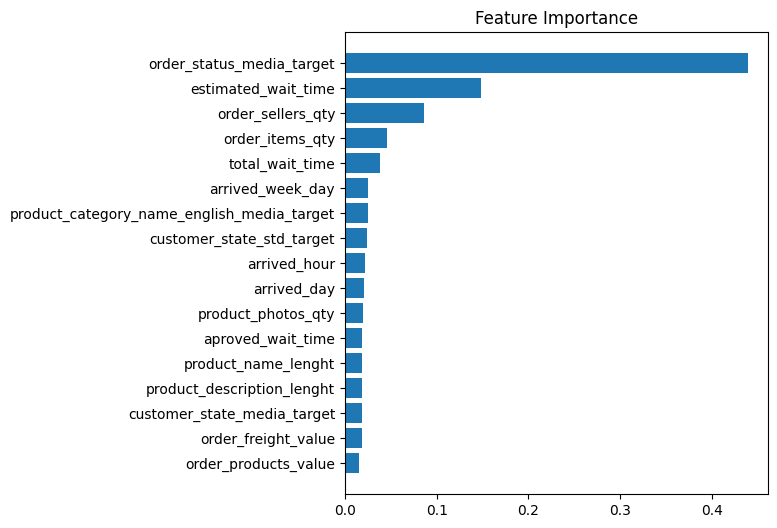

In [15]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(xtrain[cols].columns)[sorted_idx])
plt.title("Feature Importance")

plt.show()

In [16]:
predecir = pd.read_csv('../data/test_set.csv')
predecir.head()

,ID,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_city,customer_state,customer_zip_code_prefix,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty
0,0,delivered,30.00,28.20,2.0,1.0,2017-06-22 20:28:16.000000,2017-06-22 20:42:51.013492,2017-07-14 00:00:00.000000,2017-09-19 15:17:37.767855,NaN,SP,48.0,health_beauty,17.0,547.0,1.0
1,1,delivered,89.90,12.33,1.0,1.0,NaN,2017-11-20 23:34:44.641435,2017-12-01 00:00:00.000000,2017-11-23 14:41:51.640086,Caieiras,SP,NaN,bed_bath_table,58.0,188.0,1.0
2,2,delivered,890.00,86.71,1.0,1.0,2018-02-12 12:31:32.000000,2018-02-15 03:55:50.384756,2018-03-09 00:00:00.000000,2018-02-27 15:19:06.698500,Sao Caetano do Sul,SP,95.0,health_beauty,57.0,537.0,1.0
3,3,delivered,85.00,17.84,1.0,NaN,2017-07-24 05:21:16.000000,NaN,2017-08-15 00:00:00.000000,2017-07-31 19:42:27.819239,Curitiba,PR,813.0,stationery,56.0,303.0,3.0
4,4,delivered,168.98,25.31,1.0,1.0,2018-03-29 22:20:33.000000,2018-03-29 22:30:18.256631,NaN,2018-05-15 15:05:44.342452,Aracaju,SE,490.0,bed_bath_table,60.0,496.0,2.0


In [17]:
def feature_enginering(df, df_producto, df_entrega, df_estado):
    
    cols = ['order_purchase_timestamp', 'order_aproved_at', 
            'order_estimated_delivery_date', 'order_delivered_customer_date']
    df = convert_to_time(df, cols)
    df = create_time_variables(df)
    df = df.merge(df_producto, how='left')
    df = df.merge(df_entrega, how = 'left')
    df = df.merge(df_estado, how = 'left')
    df_c = df.reindex(columns = x_train.columns, fill_value=0)
    df = df_c.join(df.drop('order_status', axis=1))
    return df

In [18]:
predecir = feature_enginering(predecir, producto, entrega, estado)
predecir.head()

,canceled,delivered,invoiced,processing,shipped,unavailable,ID,order_products_value,order_freight_value,order_items_qty,...,arrived_week_day,product_category_name_english_media_target,product_category_name_english_mediana_target,product_category_name_english_std_target,order_status_media_target,order_status_mediana_target,order_status_std_target,customer_state_media_target,customer_state_mediana_target,customer_state_std_target
0,0,0,0,0,0,0,0,30.00,28.20,2.0,...,1.0,4.186776,5.0,1.268793,4.038443,5.0,1.378823,4.048783,5.0,1.365480
1,0,0,0,0,0,0,1,89.90,12.33,1.0,...,3.0,3.935175,5.0,1.414043,4.038443,5.0,1.378823,4.048783,5.0,1.365480
2,0,0,0,0,0,0,2,890.00,86.71,1.0,...,1.0,4.186776,5.0,1.268793,4.038443,5.0,1.378823,4.048783,5.0,1.365480
3,0,0,0,0,0,0,3,85.00,17.84,1.0,...,0.0,4.157182,5.0,1.261994,4.038443,5.0,1.378823,4.055556,5.0,1.360677
4,0,0,0,0,0,0,4,168.98,25.31,1.0,...,1.0,3.935175,5.0,1.414043,4.038443,5.0,1.378823,3.934783,5.0,1.481048


In [19]:
target = gbr.predict(predecir[cols])
target[target<1] = 1
target[target>5] = 5
predecir['target'] = target
predecir.head()

,canceled,delivered,invoiced,processing,shipped,unavailable,ID,order_products_value,order_freight_value,order_items_qty,...,product_category_name_english_media_target,product_category_name_english_mediana_target,product_category_name_english_std_target,order_status_media_target,order_status_mediana_target,order_status_std_target,customer_state_media_target,customer_state_mediana_target,customer_state_std_target,target
0,0,0,0,0,0,0,0,30.00,28.20,2.0,...,4.186776,5.0,1.268793,4.038443,5.0,1.378823,4.048783,5.0,1.365480,2.318855
1,0,0,0,0,0,0,1,89.90,12.33,1.0,...,3.935175,5.0,1.414043,4.038443,5.0,1.378823,4.048783,5.0,1.365480,4.230832
2,0,0,0,0,0,0,2,890.00,86.71,1.0,...,4.186776,5.0,1.268793,4.038443,5.0,1.378823,4.048783,5.0,1.365480,4.441191
3,0,0,0,0,0,0,3,85.00,17.84,1.0,...,4.157182,5.0,1.261994,4.038443,5.0,1.378823,4.055556,5.0,1.360677,4.532631
4,0,0,0,0,0,0,4,168.98,25.31,1.0,...,3.935175,5.0,1.414043,4.038443,5.0,1.378823,3.934783,5.0,1.481048,1.393914


In [20]:
predecir[['ID','target']].to_csv('../data/sum_02_R2_23.csv', index=False)

In [74]:
predecir.shape

(13800, 29)